# **Data and Analysis Plan: World Series Predictions**

- Justin Radist
- Suneet Pathangay
- Zhenzhen Liu
- Elijah Sandler

## Project Goal:

Our project aims to explore the relationship between various MLB team and individual player statistics and the performance of teams in the playoffs and World Series. We have chosen to focus on common batting and pitching statistics for teams and individual players over the last 25-30 years. We may also focus on other pieces of data such as payrolls, team injuries, fan base support and stadium dimensions. Specifically, we ask:
- What metrics - whether they be certain team statistics, individual player statistics, injuries, payrolls, fan bases, stadiums, etc. - have a material impact on playoff performance and World Series winners?
- Can we determine metrics that are greater predictors of World Series winners than regular season wins? Can we build a model that predicts these metrics for future seasons and uses these projections to predict future World Series winners?

We are using https://www.baseball-reference.com/ for our main data source, which we will webscrape from. We are not using any API.

## Pipeline Overview:

We have already written several functions for scraping the Baseball Reference website:
- build_player_url() and build_team_url()
    - Builds the URLs needed to access a certain player's or team's statistics page.
- get_batting_df() & get_pitching_df(()
    - Get tables of a team's batting and pitching statistics, respectively, for a given season.
- get_season_batting_df()
    - Get batting stats by team for a given season. We'll add a get_season_pitching_df(season) function soon.
- get_player_df()
     - Along with get_player_dict(), builds dataframes of a player's common careers stats table.

### Pipeline:

#### 1. Building URLs and Webscraping

In [257]:
# import statements
import requests
from bs4 import BeautifulSoup
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
def build_player_url(player):
    """ Constructs the URL of any MLB player's Baseball Reference stat page
    
    Args:
        player (str): a baseball player's full name
    
    Returns:
        url (str): the URL that can be used to retrieve the given player's
        stats from BaseballReference.com
    """
    first_init = player[0]
    first_two_letters = player[0:2]
    player_name_list = player.split(' ')
    # get last name except for last letter. Gets position 1 instead of -1 in case of a Jr./Sr. or II/III
    last_name = player_name_list[1][:-1]
    
    url = f"https://www.baseball-reference.com/players/{first_init}/{last_name}{first_two_letters}01.shtml"
    return url

In [3]:
def build_team_url(team, year):
    """ Constructs the URL of any MLB team's Baseball Reference stat page for a single season
    
    Args:
        team (str): 3-letter abbreviation of one of the 30 current MLB teams in existence
        year (int): the year/season to get team data for
    
    Returns:
        url (str): the URL that can be used to retrieve the given team's
        stats for the given year from BaseballReference.com
    """
    url = f"https://www.baseball-reference.com/teams/{team}/{str(year)}.shtml"
    return url

In [4]:
# testing cell
player = 'carlos correa'
team = 'NYM'
season = '2022'
player_url = build_player_url(player)
team_url = build_team_url(team, season)

In [6]:
# CURRENTLY NOT NEEDED
def get_soup(url):
    """ gets a BeautifulSoup object of a MLB player's or team's BaseballReference.com
        page by webscraping the page's HTML code
    
    Args:
        url (str): the URL that can be used to retrieve the given player's or team's
        stats from BaseballReference.com
    
    Returns:
        soup (BeautifulSoup): a beautiful soup object of the given MLB
        player's or team's BaseballReference.com page
    """
    html = requests.get(url).text
    soup = BeautifulSoup(html)
    
    return soup

In [7]:
# testing cell
player_soup = get_player_soup(player_url)
team_soup = get_soup(team_url)

#### 2. Cleaning Data and Building Dataframes

In [8]:
dict_team_batting = defaultdict(lambda: dict())
def get_batting_df(team_code, dict_team_batting=dict_team_batting, year=2023):
    """ gets the batting table for a given team. if table is not stored, adds it to dictionary """
    
    if team_code in dict_team_batting.keys():
        return dict_team_batting[year][team_code]
    
    else:
        url = f"https://www.baseball-reference.com/teams/{team_code}/{str(year)}.shtml"
        df_batting = pd.read_html(url)[0]
        
        df_filtered = pd.DataFrame()
        for idx in df_batting.index:
            try:
                int(df_batting.loc[idx, 'Rk'])
                df_filtered = pd.concat([df_filtered, df_batting.loc[idx, :]], axis=1)
            except(ValueError):
                pass
        
        
        dict_team_batting[year][team_code] = df_filtered.T
        
    return dict_team_batting[year][team_code]

In [9]:
# testing cell
get_batting_df('NYY')

,Rk,Pos,Name,Age,G,PA,AB,R,H,2B,...,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB
0,1,C,Kyle Higashioka,33,92,260,242,24,57,13,...,.274,.413,.687,85,100,5,0,1,3,0
1,2,1B,Anthony Rizzo*,33,99,421,373,45,91,14,...,.328,.378,.706,94,141,10,12,0,1,1
2,3,2B,Gleyber Torres,26,158,672,596,90,163,28,...,.347,.453,.800,118,270,19,3,0,6,0
3,4,SS,Anthony Volpe,22,159,601,541,62,113,23,...,.283,.383,.666,81,207,10,5,1,2,0
4,5,3B,DJ LeMahieu,34,136,562,497,55,121,22,...,.327,.390,.718,96,194,14,3,0,2,2
5,6,LF,Oswaldo Cabrera#,24,115,330,298,35,63,11,...,.275,.299,.574,58,89,6,2,3,2,1
6,7,CF,Harrison Bader,29,84,310,288,40,69,11,...,.278,.365,.643,75,105,6,3,1,4,0
7,8,RF,Aaron Judge,31,106,458,367,79,98,16,...,.406,.613,1.019,175,225,5,0,0,3,9
8,9,DH,Giancarlo Stanton,33,101,415,371,43,71,13,...,.275,.420,.695,87,156,11,2,0,1,3
10,10,UT,Isiah Kiner-Falefa,28,113,361,326,39,79,12,...,.306,.340,.646,78,111,12,3,1,3,0


In [10]:
dict_team_pitching = defaultdict(lambda: dict())
def get_pitching_df(team_code, dict_team_pitching=dict_team_pitching, year=2023):
    """ gets the pitching table for a given team. if table is not stored, adds it to dictionary """
    
    if team_code in dict_team_pitching[year].keys():
        return dict_team_pitching[year][team_code]
    
    else:
        url = f"https://www.baseball-reference.com/teams/{team_code}/{str(year)}.shtml"
        df_pitching = pd.read_html(url)[1]
        
        df_filtered = pd.DataFrame()
        for idx in df_pitching.index:
            try:
                int(df_pitching.loc[idx, 'Rk'])
                df_filtered = pd.concat([df_filtered, df_pitching.loc[idx, :]], axis=1)
            except(ValueError):
                pass
          
        dict_team_pitching[year][team_code] = df_filtered.T
        
    return dict_team_pitching[year][team_code]

In [11]:
# testing cell
get_pitching_df('BOS')

,Rk,Pos,Name,Age,W,L,W-L%,ERA,G,GS,...,WP,BF,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W
0,1,SP,Brayan Bello,24,12,11,.522,4.24,28,28,...,1,668,107,4.54,1.338,9.5,1.4,2.6,7.6,2.93
1,2,SP,Kutter Crawford,27,6,8,.429,4.04,31,23,...,4,527,113,3.83,1.106,7.4,1.2,2.5,9.4,3.75
2,3,SP,Tanner Houck,27,6,10,.375,5.01,21,21,...,1,463,91,4.44,1.368,8.8,1.2,3.5,8.4,2.41
3,4,SP,Chris Sale*,34,6,5,.545,4.30,20,20,...,3,425,106,3.80,1.130,7.6,1.3,2.5,11.0,4.31
4,5,SP,James Paxton*,34,7,5,.583,4.50,19,19,...,5,411,101,4.68,1.313,8.7,1.7,3.1,9.5,3.06
6,6,CL,Kenley Jansen,35,3,6,.333,3.63,51,0,...,1,188,126,3.66,1.276,8.1,1.0,3.4,10.5,3.06
7,7,RP,Josh Winckowski,25,4,4,.500,2.88,60,1,...,2,367,158,3.91,1.423,9.5,1.0,3.3,8.8,2.65
8,8,RP,Chris Martin,37,4,1,.800,1.05,55,0,...,1,199,434,2.44,1.032,7.9,0.4,1.4,8.1,5.75
9,9,RP,Brennan Bernardino*,31,2,1,.667,3.20,55,6,...,3,216,143,3.41,1.303,8.5,0.7,3.2,10.3,3.22
10,10,RP,John Schreiber,29,2,1,.667,3.86,46,2,...,1,204,119,4.52,1.414,7.9,1.2,4.8,10.2,2.12


In [47]:
def get_season_batting_df(season):
    """ Gets a table of common batting stats organized by MLB team for a given season
    Args:
        season (int): the season to get data for
    
    Returns:
         df_season_batting (pd.DataFrame): a dataframe of batting stats by team for a season
    """
    url = f'https://www.baseball-reference.com/leagues/majors/{season}.shtml'
    
    df_season_batting = pd.read_html(url)[0]
    
    return df_season_batting

In [12]:
def get_player_dict(player_soup):
    """ creates a dictionary of all an baseball player's MLB stats
        by web scraping BaseballReference.com
    
    Args:
        player_soup (BeautifulSoup): a beautiful soup object of a MLB
        player's BaseballReference.com page
    
    Returns:
        player_dict (dict): a dictionary of all the given player's MLB
        stats, where the keys are the years played in the MLB
    """
    # build dictionary of player stats row by row (season by season) without knowing years they've played
    player_stats = player_soup.find_all(class_='row_summable', id='batting_standard')[0].find_all('tbody')[0].find_all(class_='full')
    player_dict = {}
    for item in player_stats:
        # list will add current year's stats to
        temp_list = []
        # get list of tags, where each tag is different stat for current year
        tds = item.find_all('td')
        # loop through the tags and add each tags' text (stat) to the temp list
        for td in tds:
            temp_list.append(td.text)
        # add current list of stats to the year they correspond to
        player_dict[item.find('th').text] = temp_list
    
    return player_dict

In [ ]:
player_dict = get_player_dict(player_soup)

In [16]:
def get_player_df(player_dict):
    """ creates a df of all a baseball player's MLB stats
    
    Args:
        player_soup (BeautifulSoup): a dictionary of a MLB
        player's career stats by season
    
    Returns:
        player_df (pd.DataFrame): a df of all the given player's MLB
        stats
    """
    player_df = pd.DataFrame()

    for year in player_dict:
        player_series = pd.Series(player_dict[year], index=stat_names)
        player_df = pd.concat([player_df, player_series.to_frame().T])

    player_df.index = player_dict.keys()
    
    return player_df

In [18]:
player_df = get_player_df(player_dict)
player_df.head()

,Age,Tm,Lg,G,PA,AB,R,H,2B,3B,...,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,Pos,Awards
2015,20,HOU,AL,99,432,387,52,108,22,1,...,.857,135,198,10,1,0,4,2,6,"MVP-24,RoY-1"
2016,21,HOU,AL,153,660,577,76,158,36,3,...,.811,124,260,12,5,0,3,5,*6/H,
2017,22,HOU,AL,109,481,422,82,133,25,1,...,.941,155,232,12,2,0,4,5,6/D,"AS,MVP-17"
2018,23,HOU,AL,110,468,402,60,96,20,1,...,.728,99,163,17,2,0,11,3,*6/D,
2019,24,HOU,AL,75,321,280,42,78,16,1,...,.926,137,159,8,2,0,4,0,6,


In [ ]:
# THIS FUNCTION IS UNFINISHED
def get_world_series_winners(seasons):
    """ gets the World Series winners for a number or list of seasons
    
    Args:
        seasons (int or list): 'seasons' number of previous seasons
        or a list of seasons to get World Series winners for
    
    Returns:
        winners_dict (dict): keys are the seasons and values are
        are the team that won the World Series that season 
    """
    pass

    # get dataframe of playoff results for all historical seasons
    url = 'https://www.baseball-reference.com/postseason/'
    playoff_df = pd.read_html(url)[0]
    winners_dict = {}
    
    if type(seasons) == int:
        for i in range(int):
            for series in playoff_df['Series']:
                if series[0:4] == str(2023 - i):
                    if series[5:] == 'World Series':           
            
            winners_dict[2023 - i] = 
    elif type(seasons) == list:

In [96]:
# dictionary of all World Series winners between 1995 and 2023. We will use until function above is complete
ws_winners_dict = {2023: 'Texas Rangers',
                   2022: 'Houston Astros',
                   2021: 'Atlanta Braves',
                   2020: 'Los Angeles Dodgers',
                   2019: 'Washington Nationals',
                   2018: 'Boston Red Sox',
                   2017: 'Houston Astros',
                   2016: 'Chicago Cubs',
                   2015: 'Kansas City Royals',
                   2014: 'San Francisco Giants',
                   2013: 'Boston Red Sox',
                   2012: 'San Francisco Giants',
                   2011: 'St. Louis Cardinals',
                   2010: 'San Francisco Giants',
                   2009: 'New York Yankees',
                   2008: 'Philadelphia Phillies',
                   2007: 'Boston Red Sox',
                   2006: 'St. Louis Cardinals',
                   2005: 'Chicago White Sox',
                   2004: 'Boston Red Sox',
                   2003: 'Florida Marlins',
                   2002: 'Anaheim Angels',
                   2001: 'Arizona Diamondbacks',
                   2000: 'New York Yankees',
                   1999: 'New York Yankees',
                   1998: 'New York Yankees',
                   1997: 'Florida Marlins',
                   1996: 'New York Yankees',
                   1995: 'Atlanta Braves'}

## Visualizations:

This visualization plots how many World Series winners led the league in each stat during the regular season of the year they won the World Series.

In [205]:
# get the world series information
world_series = pd.read_html("https://www.baseball-reference.com/postseason/world-series.shtml")
table = world_series[0]

# rename win and win1 to AL win and NL win
table.rename(columns={table.columns[2]: 'AL Wins'}, inplace=True)
table.rename(columns={table.columns[3]: 'NL Wins'}, inplace=True)
# print out the last 20 world series data
table.head(20)

,Year,AL Winner,AL Wins,NL Wins,NL Winner,Series MVP
0,2023,Texas Rangers,4,1,Arizona Diamondbacks,Corey Seager
1,2022,Houston Astros,4,2,Philadelphia Phillies,Jeremy Peña
2,2021,Houston Astros,2,4,Atlanta Braves,Jorge Soler
3,2020,Tampa Bay Rays,2,4,Los Angeles Dodgers,Corey Seager
4,2019,Houston Astros,3,4,Washington Nationals,Stephen Strasburg
5,2018,Boston Red Sox,4,1,Los Angeles Dodgers,Steve Pearce
6,2017,Houston Astros,4,3,Los Angeles Dodgers,George Springer
7,2016,Cleveland Indians,3,4,Chicago Cubs,Ben Zobrist
8,2015,Kansas City Royals,4,1,New York Mets,Salvador Perez
9,2014,Kansas City Royals,3,4,San Francisco Giants,Madison Bumgarner


In [206]:
# add world series champions information to table
champ_team = []
for index, row in table.iterrows():
    if row['AL Wins'] == '4':
        champ_team.append({'Year': row['Year'], 'Champion Team': row['AL Winner']})
    if row['NL Wins'] == '4':
        champ_team.append({'Year': row['Year'], 'Champion Team': row['NL Winner']})
champ_team[:20]

[{'Year': '2023', 'Champion Team': 'Texas Rangers'},
 {'Year': '2022', 'Champion Team': 'Houston Astros'},
 {'Year': '2021', 'Champion Team': 'Atlanta Braves'},
 {'Year': '2020', 'Champion Team': 'Los Angeles Dodgers'},
 {'Year': '2019', 'Champion Team': 'Washington Nationals'},
 {'Year': '2018', 'Champion Team': 'Boston Red Sox'},
 {'Year': '2017', 'Champion Team': 'Houston Astros'},
 {'Year': '2016', 'Champion Team': 'Chicago Cubs'},
 {'Year': '2015', 'Champion Team': 'Kansas City Royals'},
 {'Year': '2014', 'Champion Team': 'San Francisco Giants'},
 {'Year': '2013', 'Champion Team': 'Boston Red Sox'},
 {'Year': '2012', 'Champion Team': 'San Francisco Giants'},
 {'Year': '2011', 'Champion Team': 'St. Louis Cardinals'},
 {'Year': '2010', 'Champion Team': 'San Francisco Giants'},
 {'Year': '2009', 'Champion Team': 'New York Yankees'},
 {'Year': '2008', 'Champion Team': 'Philadelphia Phillies'},
 {'Year': '2007', 'Champion Team': 'Boston Red Sox'},
 {'Year': '2006', 'Champion Team': 'St

In [223]:
# creating empty storages for the team batting data
AB = []
R = []
H = []
two_B = []
three_B = []
HR = []
RBI = []
SB = []
CS = []
BB = []
SO = []
BA = []
OBP = []
SLG = []
OPS = []
TB = []
HBP = []
SF = []

In [224]:
def World_Series_Winner_Leading_Data(team, year):
    """ Get the leading data from a World Series winner
    
    Args:
        team (string): MLB team name
        year (string): the year that the team won the World Series
    
    Returns:
        None
    """
    team_replaced = team.replace(" ", "+")
    url = f'https://www.baseball-reference.com/search/search.fcgi?hint=&search={team_replaced}+{year}&pid=&idx='
    tables = pd.read_html(url)

    team_bat = tables[0]

    target_row = team_bat[team_bat['Name'] == "Rank in 15 AL teams"]

    if not target_row.empty:
        # loop through the columns of the target row
        for column_name in target_row.columns:
            rank = target_row[column_name].values[0]

            if rank == '1':
                if column_name == 'AB':
                    AB.append(team)
                elif column_name == 'R':
                    R.append(team)
                elif column_name == 'H':
                    H.append(team)
                elif column_name == '2B':
                    two_B.append(team)
                elif column_name == '3B':
                    three_B.append(team)
                elif column_name == 'HR':
                    HR.append(team)
                elif column_name == 'RBI':
                    RBI.append(team)
                elif column_name == 'SB':
                    SB.append(team)
                elif column_name == 'CS':
                    CS.append(team)
                elif column_name == 'BB':
                    BB.append(team)
                elif column_name == 'SO':
                    SO.append(team)
                elif column_name == 'BA':
                    BA.append(team)
                elif column_name == 'OBP':
                    OBP.append(team)
                elif column_name == 'SLG':
                    SLG.append(team)
                elif column_name == 'OPS':
                    OPS.append(team)
                elif column_name == 'TB':
                    TB.append(team)
                elif column_name == 'HBP':
                    HBP.append(team)
                elif column_name == 'SF':
                    SF.append(team)

In [225]:
for t in champ_team[:5]:
    year = t['Year']
    team = t['Champion Team']
    World_Series_Winner_Leading_Data(team, year)

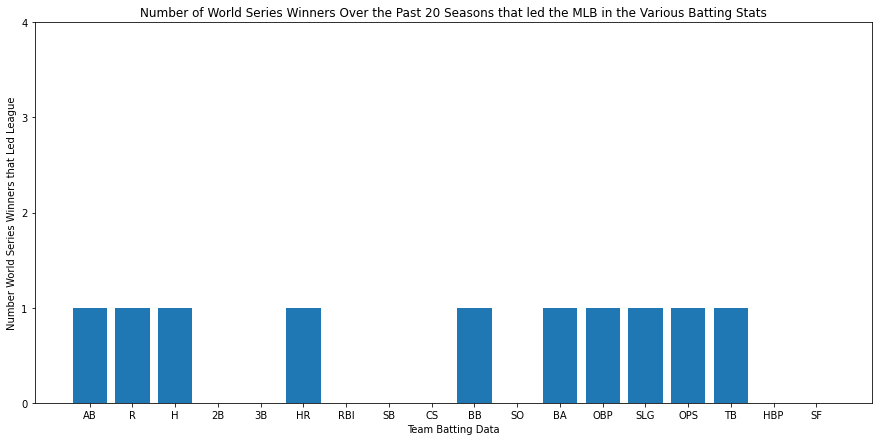

In [229]:
# create bar chart of stats and how often World Series winners led the league in them
list_names = ['AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'TB', 'HBP', 'SF']
list_lengths = [len(AB), len(R), len(H), len(two_B), len(three_B), len(HR), len(RBI), len(SB), len(CS), len(BB), len(SO), len(BA), len(OBP),
                len(SLG), len(OPS), len(TB), len(HBP), len(SF)]

#list_names = ['H', 'HR', 'RBI', 'BA', 'OBP', 'SLG', 'OPS']
#list_lengths = [len(H), len(HR), len(RBI), len(BA), len(OBP), len(SLG), len(OPS)]

plt.bar(list_names, list_lengths)

plt.yticks([0, 1, 2, 3, 4])

plt.xlabel('Team Batting Data')
plt.ylabel('Number World Series Winners that Led League')
plt.title('Number of World Series Winners Over the Past 20 Seasons that led the MLB in the Various Batting Stats')
plt.gcf().set_size_inches(15, 7)
plt.show()

As you can see in the graph above, for every batting stat, either 1 or none of the last 20 World Series winners led the league in it the year they won. Therefore, one next step is to expand from only counting World Series winners that led the entire MLB in a stat to counting World Series winners that were one of the top 3 or 5 teams in the MLB for a stat that season.

The goal of the code in the cell below is to make a list 2-item lists where the 1st item is the mean value for all teams in each season for each passed batting stat, and the 2nd is the stat value for the team that won the World Series that year.
Then, in the following cell: for each stat, we plot 2 scatter sets on the same plot: 1 color for the mean values by season, the 2nd color the set of values for World Series winners by season. We would look to see if World Series winners consistently had well-above average values for any stat, which would indicate there might be some relationship between that stat
and playoff success.

In [238]:
seasons = []
batting_stats = {'H': [],
                'HR': [],
                'RBI': [],
                'BA': [],
                'OPS': []}

# loop backwards through the past n seasons
for i in range(10):
    season = 2023 - i
    seasons.append(season)
    # pull df for current loop's season, set team name as the index
    df_season_batting = get_season_batting_df(season).set_index('Tm')
    time.sleep(4)
    # loop through all the stats in the dictionary initialized above
    for stat in list(batting_stats.keys()):
        # get the average team value for the current stat in the current season
        avg_stat_val = df_season_batting[stat][:30].astype(float).mean()
        
        # get the value for the current stat for the team that won the World Series in the current loop's season
        ws_winner = ws_winners_dict[season]
        ws_winner_stat_val = float(df_season_batting.loc[ws_winner][stat])
        
        # create 2-item list of mean stat value and World Series winner stat value for the current season
        temp_stat_list = [round(avg_stat_val, 3), round(ws_winner_stat_val, 3)]
        # add the 2-item list to list of the respective stat in the batting stats dictionary
        batting_stats[stat].append(temp_stat_list)

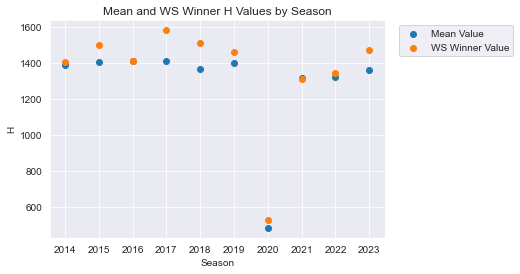

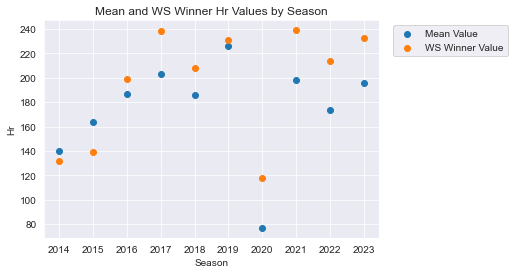

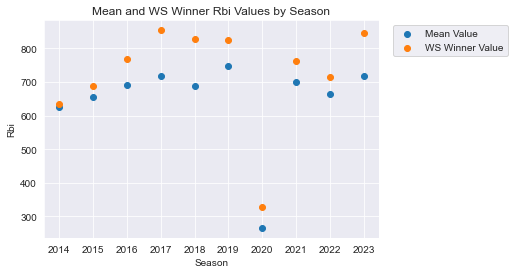

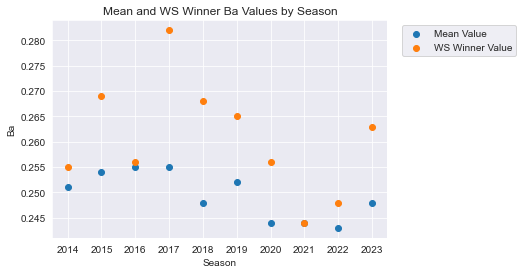

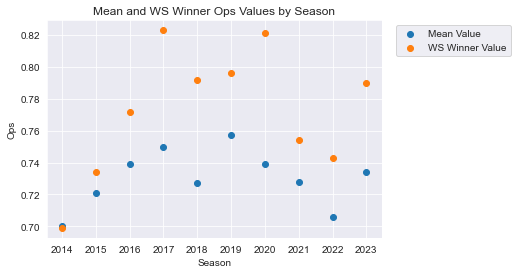

In [260]:
# plot mean team and WS winner values for each stat by season
sns.set_style('darkgrid')
for stat, values in batting_stats.items():
    temp_array = np.array(values)
    plt.scatter(seasons, temp_array[:, 0], label='Mean Value')
    plt.scatter(seasons, temp_array[:, 1], label='WS Winner Value')
    plt.xticks(seasons)
    plt.legend(bbox_to_anchor=(1.4, 1))
    plt.xlabel('Season')
    plt.ylabel(stat.capitalize())
    plt.title(f'Mean and WS Winner {stat.capitalize()} Values by Season')
    plt.show()

Almost all World Series winners have been above average in each of the above 5 batting statistics over the last 10 seasons. Coupled with our conclusions from the first visualization, we know that most World Series winners have above values for these statistics but almost always aren't the league leader. Therefore, another next step will be to dig deeper into what percentiles World Series winners tend to fall into for each of these popular batting (and eventually pitching) stats.

## Analysis/ML Plan:

The model that we feel that will be most appropriate for this would be a multi variate regression model to calculate the playoff performance and the chance of a team winning the World Series. Further more, we would figure out which which metrics are the greatest predictors of World Series winners. We can investigate linear regression with variety of inputs and predictors such as individual player statistics,payrolls,and injuries to see if we can accuractely predict whether a team will win the World Series. All of these factors could definitely play a roll in our model, however the one that stands out the most would probably be player statistics. Some player statistics that could have a huge impact woould be important stats such as batting average. It would also be important to consider other forms of regresison such as polynomial regresison. In conclusion, we will probably ending using a multi variate regression model to calculate playoff performances.

However, we recognize that playoff performance is a qualitative data point (i.e., "won World Series," "lost in NLCS," etc.), and while it can be quantified (e.g., made playoffs = 1, won Wild Card round = 2, ..., won World Series = 5), there's only a few possible outcomes, which may make regression difficult to implement usefully. Therefore, we expect we might need to switch to more qualitative ML models such as multivariate perceptrons, decision trees, random forests, etc. to get higher utility results. For instance, we might use a team's batting average, OPS, pitching staff ERA, and pitching staff WHIP to predict whether a team will make it to the playoffs - if they do, then predict whether a team will win the Wild Card round ... - until eventually, the remaining teams will be used to predict which will win the World Series.  